Work book Notes:

In this notebook we will first use stacking models on preprocessed data with no polynomial form. Then will build stacking models on polynomial data forms.



In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_train = pd.read_csv('F:/Titanic/data/train.csv')

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
def replace_age_fraction(df_train):
    df_train.loc[df_train['Age']<1,'Age'] = df_train.loc[df_train['Age']<1,'Age']*100
    print len(df_train.loc[df_train['Age']<1,'Age'])


In [5]:
def replace_na_to_mode(df_train):
    for i in df_train.columns:
    
        if(i in ['PassengerId','Name']):
            pass
        else:
            print i
            df_train[i]= df_train[i].fillna(df_train[i].mode()[0]) # fill na by mode Values

In [6]:
replace_age_fraction(df_train)

0


In [7]:
replace_na_to_mode(df_train)

Survived
Pclass
Sex
Age
SibSp
Parch
Ticket
Fare
Cabin
Embarked


### Create polynomial of column values

In [8]:
def polynomial_data(dataframe, column_name, power =1):
    tmp_df = pd.DataFrame()
    col_degree = [column_name+str(i) for i in range(1,power+1)]
    
    for i in range(1,power+1):
        tmp_df[col_degree[i-1]]=dataframe[column_name]**i
        
    return tmp_df

In [37]:
# df_poly = pd.concat([polynomial_data(df_train,'Pclass',7), 
#                  polynomial_data(df_train,'Age',6),
#                  polynomial_data(df_train,'Fare',9), 
#                  df_train], axis=1)

In [46]:
df_poly = pd.concat([polynomial_data(df_train,'Pclass',17), 
                 polynomial_data(df_train,'Age',16),
                 polynomial_data(df_train,'Fare',19), 
                 df_train], axis=1)

In [47]:
import h2o

In [48]:
h2o.init(max_mem_size='6g')

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,2 mins 00 secs
H2O cluster version:,3.10.3.4
H2O cluster version age:,1 month and 4 days
H2O cluster name:,H2O_from_python_hamza_4wk45t
H2O cluster total nodes:,1
H2O cluster free memory:,5.313 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [49]:
# upload data to h2o frame
hdf= h2o.H2OFrame(df_poly)

# factor the class label
hdf['Survived']= hdf['Survived'].asfactor()

# create train and validation datasets for model learining with 70 and 30 percent ratio
hdf_train, hdf_validate = hdf.split_frame(ratios=[0.70], seed=10)


# create input and response column names
response = 'Survived'
input_name= hdf.col_names
input_name.remove(response)
print input_name

Parse progress: |█████████████████████████████████████████████████████████| 100%
[u'Pclass1', u'Pclass2', u'Pclass3', u'Pclass4', u'Pclass5', u'Pclass6', u'Pclass7', u'Pclass8', u'Pclass9', u'Pclass10', u'Pclass11', u'Pclass12', u'Pclass13', u'Pclass14', u'Pclass15', u'Pclass16', u'Pclass17', u'Age1', u'Age2', u'Age3', u'Age4', u'Age5', u'Age6', u'Age7', u'Age8', u'Age9', u'Age10', u'Age11', u'Age12', u'Age13', u'Age14', u'Age15', u'Age16', u'Fare1', u'Fare2', u'Fare3', u'Fare4', u'Fare5', u'Fare6', u'Fare7', u'Fare8', u'Fare9', u'Fare10', u'Fare11', u'Fare12', u'Fare13', u'Fare14', u'Fare15', u'Fare16', u'Fare17', u'Fare18', u'Fare19', u'PassengerId', u'Pclass', u'Name', u'Sex', u'Age', u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked']


## Super Learning:

As Super learning is process learning of two layer of models, i.e. we in first layer(base model) we will use Random Forest, Gradient Boosting Machine, Naive Bayse and Deep Learning as Meta Learner

In [50]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator

In [52]:
nfolds =5
# Train and cross-validate a GBM
my_gbm = H2OGradientBoostingEstimator(ntrees=200,
                                      max_depth=6,
                                      min_rows=2,
                                      learn_rate=0.2,
                                      nfolds=nfolds,
                                      fold_assignment="Modulo",
                                      keep_cross_validation_predictions=True,
                                      seed=1)
my_gbm.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)


gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [55]:
# Train and cross-validate a RF
my_rf = H2ORandomForestEstimator(ntrees=200,
                                 nfolds=nfolds,
                                 fold_assignment="Modulo",
                                 keep_cross_validation_predictions=True,
                                 seed=1)
my_rf.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

drf Model Build progress: | (failed)


EnvironmentError: Job with key $03017f00000132d4ffffffff$_a1f76f9822c3511b50adcc4a12c04fa7 failed with an exception: hex.tree.DHistogram$StepOutOfRangeException: step=0.0, xbins = 32, maxEx = Infinity, min = 9.384329526866785E33
stacktrace: 
hex.tree.DHistogram$StepOutOfRangeException: step=0.0, xbins = 32, maxEx = Infinity, min = 9.384329526866785E33
	at hex.tree.DHistogram.<init>(DHistogram.java:193)
	at hex.tree.DHistogram.make(DHistogram.java:348)
	at hex.tree.DTree$Split.nextLevelHistos(DTree.java:285)
	at hex.tree.DTree$DecidedNode.<init>(DTree.java:513)
	at hex.tree.SharedTree.makeDecided(SharedTree.java:568)
	at hex.tree.SharedTree$ScoreBuildOneTree.onCompletion(SharedTree.java:491)
	at jsr166y.CountedCompleter.__tryComplete(CountedCompleter.java:425)
	at jsr166y.CountedCompleter.tryComplete(CountedCompleter.java:383)
	at water.LocalMR.compute2(LocalMR.java:91)
	at water.LocalMR.compute2(LocalMR.java:76)
	at water.LocalMR.compute2(LocalMR.java:76)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1220)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.popAndExecAll(ForkJoinPool.java:904)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:977)
	at jsr166y.ForkJoinPool.runWorker(ForkJoinPool.java:1477)
	at jsr166y.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:104)


In [ ]:
# Train and cross-validate a NB
my_nb =H2ONaiveBayesEstimator(seed =1,
                              nfolds=nfolds,
                              fold_assignment="Modulo",
                              keep_cross_validation_predictions=True)
my_nb.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

In [56]:
# Train and cross-validate a DL
my_dl = H2ODeepLearningEstimator(seed =1,  
                              hidden=[200,200],
                              epochs =100,
                              l2= 1e-5,
#                               l1=1e-2,
                              activation = 'MaxoutWithDropout',
                              distribution = 'AUTO',
                              nfolds=nfolds,
                              fold_assignment="Modulo",
                              keep_cross_validation_predictions=True)
my_dl.train(x =input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [ ]:
# Train a stacked ensemble using the GBM and GLM above
ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_binomial",
                                       base_models=[my_gbm.model_id, my_rf.model_id])
ensemble.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

Train accuracy: 0.999730094467
valid accuracy: 0.904888006179


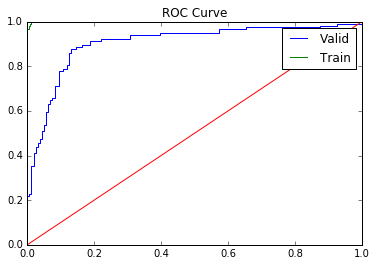

In [57]:
def model_performance(model =  ensemble):
    print 'Train accuracy:', model.auc(train=True)
    print 'valid accuracy:', model.auc(valid=True)

    roc_valid = model.roc(valid=True)
    roc_train= model.roc()

    plt.plot(roc_valid[0],roc_valid[1])
    plt.plot(roc_train[0],roc_train[1])
    plt.plot(np.arange(0.0,1.1,0.1),np.arange(0.0,1.1,0.1))
    
    plt.title('ROC Curve')
    plt.legend(['Valid','Train'])
    plt.show()

model_performance(ensemble)

In [ ]:
# Train a stacked ensemble using the GBM  GLM and NB above
ensemble1_0 = H2OStackedEnsembleEstimator(model_id="my_ensemble_binomial1_0",
                                       base_models=[my_gbm.model_id, my_rf.model_id, my_nb.model_id])
ensemble1_0.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

In [ ]:
model_performance(ensemble1_0)

In [ ]:
# Train a stacked ensemble using the GBM  GLM and DL above
ensemble1_1 = H2OStackedEnsembleEstimator(model_id="my_ensemble_binomial1_1",
                                       base_models=[my_gbm.model_id, my_rf.model_id, my_dl.model_id])
ensemble1_1.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

In [ ]:
model_performance(ensemble1_1)

In [ ]:
# Train a stacked ensemble using the GBM  GLM  DL and NB above
ensemble1_2 = H2OStackedEnsembleEstimator(model_id="my_ensemble_binomial1_2",
                                       base_models=[my_gbm.model_id, my_rf.model_id, my_dl.model_id, my_nb.model_id])
ensemble1_2.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

In [ ]:
model_performance(ensemble1_2)

In [58]:
# Train a stacked ensemble using the GBM   DL above
ensemble1_3 = H2OStackedEnsembleEstimator(model_id="my_ensemble_binomial1_3",
                                       base_models=[my_gbm.model_id, my_dl.model_id])
ensemble1_3.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

stackedensemble Model Build progress: |███████████████████████████████████| 100%


Train accuracy: 0.985318263608
valid accuracy: 0.907315458457


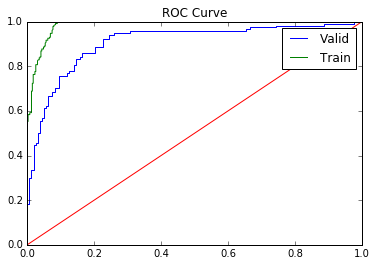

In [62]:
model_performance(ensemble1_3)

## Predict with Model 

In [63]:
df_test = pd.read_csv('F:/Titanic/data/test.csv')

replace_age_fraction(df_test)
replace_na_to_mode(df_test)

0
Pclass
Sex
Age
SibSp
Parch
Ticket
Fare
Cabin
Embarked


In [64]:
df_poly_test = pd.concat([polynomial_data(df_train,'Pclass',17), 
                 polynomial_data(df_train,'Age',16),
                 polynomial_data(df_train,'Fare',19), 
                 df_train], axis=1)

In [65]:
hdf_test = h2o.H2OFrame(df_poly_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [66]:
def get_prediction(model= ensemble1_1, hdf_data = hdf_test, create_frame=True):
    prediction = model.predict(hdf_data)
    
    if(create_frame == True):
        lst_id=range(892,len(df_test['Age'])+892)

        #initialize dataframe and save prediction values in Survived columns and lst_id in Passenger id coloums
        df_submission = pd.DataFrame()
        df_submission['PassengerId'] = lst_id
        df_submission['Survived'] = prediction['predict'].as_data_frame()
        
        return df_submission

    else:
    #     prediction['predict'].unique()
        return prediction

In [69]:
df_submission = get_prediction(my_gbm,hdf_data=hdf_test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [70]:
df_submission.to_csv('F:/Titanic/data/submission.csv',index=False)

In [34]:
# h2o.shutdown()